In [208]:
import tensorflow as tf
from tensorflow import keras

from nn.models import C6_4l_clf_maxi_nonprm, swish_activation, C6_4l_clf_maxi
from nn import datasets
from hstar import gghzz, c6, msq
from hzz import zpair, angles

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [209]:
GEN=7
SEED=373485

EVENT_NUM=99

OUTPUT_DIR='outputs/def'
SAMPLE_DIR='..'

In [210]:
sample = gghzz.Process(  
    (1.4783394, SAMPLE_DIR + '/ggZZ2e2m_all_new.csv', 33),
    (0.47412769, SAMPLE_DIR + '/ggZZ4e_all_new.csv', 33),
    (0.47412769, SAMPLE_DIR + '/ggZZ4m_all_new.csv', 33)
)

#sample.events = sample.events[1000:]

print(sample.events.kinematics.shape[0])

99


In [215]:
#base_size = EVENT_NUM # for train and validation data each

#fraction = 3*base_size/sample.events.kinematics.shape[0] # fraction of the dataset that is actually needed

#sample.events = sample.events.sample(frac=fraction, random_state=SEED)[-base_size:]


z_chooser = zpair.ZPairChooser(bounds1=(50,115), bounds2=(50,115), algorithm='leastsquare')
l1_1, l2_1, l1_2, l2_2 = sample.events.filter(z_chooser)

kin_variables = angles.calculate(l1_1, l2_1, l1_2, l2_2)

true_size = kin_variables.shape[0]

c6_values = np.linspace(-20,20,201)

c6_mod = c6.Modifier(amplitude_component = msq.Component.SIG, c6_values = [-5,-1,0,1,5])
c6_weights, c6_prob = c6_mod.modify(sample=sample, c6=c6_values)

print(true_size)

95


In [212]:
data = []

signal_weights = c6_prob
background_weights = tf.convert_to_tensor(sample[msq.Component.SIG].probabilities)[:,tf.newaxis]

for i in range(len(c6_values)):
    param = c6_values[i]

    sig_weights = tf.cast(signal_weights.T[i][:,tf.newaxis], tf.float32)
    bkg_weights = tf.cast(background_weights, tf.float32)

    data.append(tf.concat([kin_variables, tf.ones(kin_variables.shape[0])[:,tf.newaxis]*param, sig_weights, bkg_weights], axis=1))

test_data = tf.reshape(tf.convert_to_tensor(data), (tf.convert_to_tensor(data).shape[0]*tf.convert_to_tensor(data).shape[1], tf.convert_to_tensor(data).shape[2]))

print(test_data)

scaler = StandardScaler()

# for GEN 7
#scaler.mean_ = np.array([0.00019189256612400722, 0.6705156706726307, 0.672182766320336, -0.002330860289531429, 0.0006044017928423123, 91.30343432815204, 91.34168283098509, 258.4664139166857])
#scaler.scale_ = np.array([0.87351127, 0.54823019, 0.54611839, 1.79371613, 1.75821199, 5.26457924, 5.23341484, 81.40698443])

# for GEN 8
#scaler.mean_ = np.array([-0.0031632037149649183, 0.6709139748958037, 0.6713568278628346, -0.0013302089262169912, -6.864847530142441e-05, 91.28878797551799, 91.33838398300865, 258.7329571302806])
#scaler.scale_ = np.array([0.8731540510089402, 0.5475399159778886, 0.5468877066551572, 1.7939801195228402, 1.761634667204255, 5.285707478337055, 5.28228227727623, 82.53483099791613])

# for GEN 9
#scaler.mean_ = np.array([0.00019189256612400722, 0.6705156706726307, 0.672182766320336, -0.002330860289531429, 0.0006044017928423123, 91.30343432815204, 91.34168283098509, 258.4664139166857])
#scaler.scale_ = np.array([0.8735112733447693, 0.5482301877890214, 0.5461183930995697, 1.7937161274598072, 1.7582119943056935, 5.264579236544669, 5.233414841237367, 81.40698443389775])

# for GEN 10
#scaler.mean_ = [-0.0031632037149649183, 0.6709139748958037, 0.6713568278628346, -0.0013302089262169912, -6.864847530142441e-05, 91.28878797551799, 91.33838398300865, 258.7329571302806]
#scaler.scale_ = [0.8731540510089402, 0.5475399159778886, 0.5468877066551572, 1.7939801195228402, 1.761634667204255, 5.285707478337055, 5.28228227727623, 82.53483099791613]

# for GEN 11
scaler.mean_ = [0.0041883523529701126, 0.6585512602003579, 0.6590724303775782, 0.008898707902610995, 0.0029265562530066598, 91.70022920117556, 91.71387359595622, 260.1704808930588]
scaler.var_ = [0.7511071029253801, 0.3090641744523269, 0.3097333402758006, 3.1408749557745717, 3.085505507693849, 21.072290878468102, 20.840327899463848, 5322.945363090034]
scaler.scale_ = [0.8666643542487369, 0.555935404927881, 0.5565369172622788, 1.7722513805255087, 1.7565607042439066, 4.590456500008262, 4.565120797904897, 72.95851809823192]

# GEN 6 prm
scaler.mean_ = [-0.020684812321007006, 0.68440520223879, 0.6356534609956606, 0.07556516068918845, -0.08531723095134633, 91.58549114133491, 91.76030894576526, 259.3401742841377, 0.0]
scaler.var_ = [0.7732219137837286, 0.2785609453993477, 0.35190943456939366, 3.1950020718812944, 3.0129579815722316, 20.371406024026648, 20.54153544201586, 5087.888394575287, 133.46666664619733]
scaler.scale_ = [0.8793303780626077, 0.5277887317851223, 0.5932195500566326, 1.78745687273324, 1.7357874240736484, 4.513469399921378, 4.532277070305374, 71.32943568103765, 11.55277744294407]


test_data = tf.concat([scaler.transform(test_data[:,:9]), test_data[:,9:]], axis=1)

print(test_data, test_data.shape)

mu = tf.reduce_sum(test_data[:,:9], axis=0)/test_data.shape[0]

print('Mean (after):', mu)

sigma = tf.math.reduce_std(test_data[:,:9], axis=0)

print('sigma (after):', sigma)

tf.Tensor(
[[-9.9499828e-01  9.9364811e-01  8.3830374e-01 ... -2.0000000e+01
   2.7881251e-05  3.5714859e-04]
 [-9.2265052e-01  6.9582748e-01 -7.4989164e-01 ... -2.0000000e+01
   6.3441019e-04  5.4565538e-03]
 [-8.3061111e-01  9.7401160e-01  9.7567606e-01 ... -2.0000000e+01
   1.2324805e-06  3.4591376e-05]
 ...
 [-9.6769559e-01  5.9346020e-01  9.9897188e-01 ...  2.0000000e+01
   5.9361226e-04  2.2122308e-03]
 [ 9.5969659e-01  9.9914330e-01  7.5288004e-01 ...  2.0000000e+01
   2.9260592e-04  1.2805922e-03]
 [-9.0324563e-01  1.0381727e-01  9.9998212e-01 ...  2.0000000e+01
   1.0429012e-04  7.2731980e-04]], shape=(19095, 11), dtype=float32)
tf.Tensor(
[[-1.1080176e+00  5.8592176e-01  3.4161094e-01 ... -1.7311854e+00
   2.7881251e-05  3.5714859e-04]
 [-1.0257416e+00  2.1641769e-02 -2.3356364e+00 ... -1.7311854e+00
   6.3441019e-04  5.4565538e-03]
 [-9.2107165e-01  5.4871655e-01  5.7318169e-01 ... -1.7311854e+00
   1.2324805e-06  3.4591376e-05]
 ...
 [-1.0769681e+00 -1.7231327e-01  6.124518

In [213]:
print(test_data, test_data.shape)

tf.Tensor(
[[-1.1080176e+00  5.8592176e-01  3.4161094e-01 ... -1.7311854e+00
   2.7881251e-05  3.5714859e-04]
 [-1.0257416e+00  2.1641769e-02 -2.3356364e+00 ... -1.7311854e+00
   6.3441019e-04  5.4565538e-03]
 [-9.2107165e-01  5.4871655e-01  5.7318169e-01 ... -1.7311854e+00
   1.2324805e-06  3.4591376e-05]
 ...
 [-1.0769681e+00 -1.7231327e-01  6.1245185e-01 ...  1.7311854e+00
   5.9361226e-04  2.2122308e-03]
 [ 1.1149181e+00  5.9633350e-01  1.9761078e-01 ...  1.7311854e+00
   2.9260592e-04  1.2805922e-03]
 [-1.0036738e+00 -1.1000385e+00  6.1415482e-01 ...  1.7311854e+00
   1.0429012e-04  7.2731980e-04]], shape=(19095, 11), dtype=float32) (19095, 11)


In [214]:
model = keras.models.load_model(OUTPUT_DIR + f'/ckpt/checkpoint.model_{GEN}.tf', custom_objects={'C6_4l_clf_maxi': C6_4l_clf_maxi, 'swish_activation': swish_activation})

In [277]:
rndint = np.random.choice(np.arange(0,true_size)).astype(int)

print(rndint)

data = test_data[rndint::true_size,:9][:,np.newaxis]

print(data.shape)

pred = model.predict(data, verbose=2)

real_ratios = test_data[rndint::true_size,9]/test_data[rndint::true_size,10]

pred = tf.convert_to_tensor(pred)

ratios = tf.squeeze(pred/(1-pred), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

print(real.shape)
print(pred.shape)

46
(201, 1, 9)
7/7 - 1s - 1s/epoch - 192ms/step
tf.Tensor(
[[0.11971255]
 [0.12788439]
 [0.13653319]
 [0.1456918 ]
 [0.15539183]
 [0.16566391]
 [0.17653602]
 [0.18803278]
 [0.20017514]
 [0.21297893]
 [0.22645295]
 [0.24059296]
 [0.2553745 ]
 [0.2707466 ]
 [0.28662968]
 [0.30292556]
 [0.31953305]
 [0.3363655 ]
 [0.3533629 ]
 [0.37049115]
 [0.38773564]
 [0.40508565]
 [0.42252326]
 [0.44001335]
 [0.45750132]
 [0.47491598]
 [0.4921742 ]
 [0.5091861 ]
 [0.52585894]
 [0.542099  ]
 [0.55781496]
 [0.5729225 ]
 [0.58734965]
 [0.6010438 ]
 [0.6139754 ]
 [0.6261401 ]
 [0.6375572 ]
 [0.64826506]
 [0.6583148 ]
 [0.667765  ]
 [0.67667764]
 [0.6851129 ]
 [0.6931297 ]
 [0.7007822 ]
 [0.7081203 ]
 [0.71519023]
 [0.72203404]
 [0.72869015]
 [0.7351933 ]
 [0.7415749 ]
 [0.7478623 ]
 [0.75407946]
 [0.76024646]
 [0.76637864]
 [0.7724873 ]
 [0.7785784 ]
 [0.7846538 ]
 [0.7907092 ]
 [0.7967368 ]
 [0.80272394]
 [0.80865514]
 [0.8145123 ]
 [0.8202776 ]
 [0.8259338 ]
 [0.83146626]
 [0.8368634 ]
 [0.84211725]
 [0

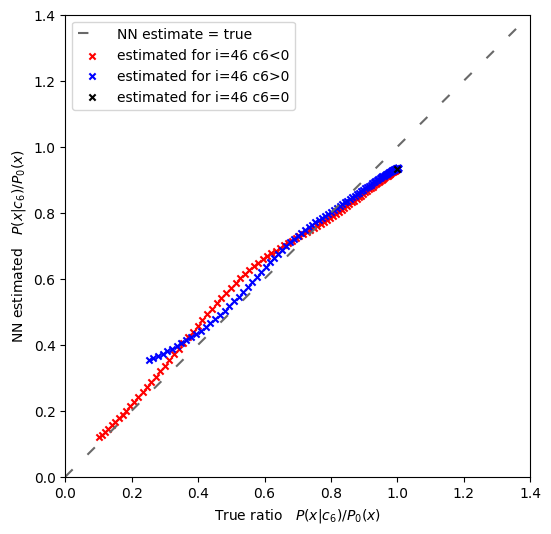

In [278]:
lnspc = np.linspace(0.0,1.4)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real[:100], pred[:100], color='r', s=20, marker='x', label=f'estimated for i={rndint} c6<0')
plt.scatter(real[101:], pred[101:], color='b', s=20, marker='x', label=f'estimated for i={rndint} c6>0')
plt.scatter(real[100], pred[100], color='k', s=20, marker='x', label=f'estimated for i={rndint} c6=0')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,1.4)
plt.ylim(0.0,1.4)
plt.legend()
#19
plt.show()

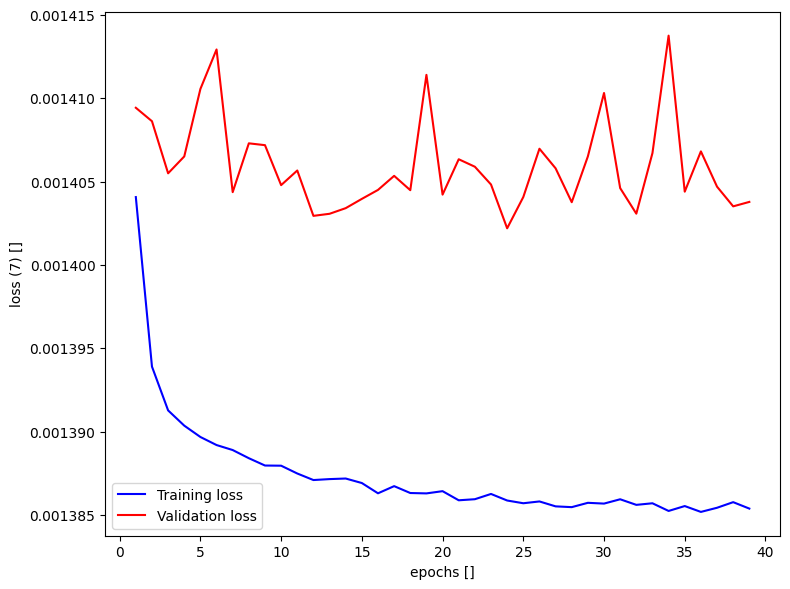

In [174]:
hist_prm = ''

with open(OUTPUT_DIR + f'/history/history_{GEN}.txt', 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss ({GEN}) []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [175]:
predictions = []
real_ratios = []

arr_len = test_data.shape[0]/len(c6_values)

for i in range(len(c6_values)):
    c6 = c6_values[i]
    data = test_data[int(i*arr_len):int((i+0.5)*arr_len),0][:,np.newaxis]
    pred = model.predict(data)
    predictions.append(pred)

    real_ratio = test_data[int(i*arr_len):int((i+0.5)*arr_len),2]/test_data[int((i+0.5)*arr_len):int((i+1)*arr_len),2]
    real_ratios.append(real_ratio)

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios)

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios)

InvalidArgumentError: Graph execution error:

Detected at node c6_4l_clf_maxi/dense_55/MatMul defined at (most recent call last):
  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/runpy.py", line 86, in _run_code

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_44259/89026611.py", line 9, in <module>

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/raven/u/griesemx/ggZZ_work/higgs-offshell-interpretation/nn/models.py", line 64, in call

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,1], In[1]: [9,2000] 0 0
	 [[{{node c6_4l_clf_maxi/dense_55/MatMul}}]] [Op:__inference_predict_function_40972]

In [ ]:
real = real_ratios.numpy()
pred = ratios.numpy()

lnspc = np.linspace(0.6,1.2)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label='Estimated data')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()

In [ ]:
hist_prm = ''

with open(f'outputs/m4l/single/history/history_2_m4l.txt', 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,101)

In [ ]:
fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel('loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()